<a href="https://colab.research.google.com/github/Adeola23/g05-used-cars/blob/master/Used%20cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle

In [3]:
import os
os.environ['KAGGLE_USERNAME'] = "ade0laa" # username from the json file
os.environ['KAGGLE_KEY'] = "af73d20084c82be126c444a8187061b6" # key from the json file
!kaggle datasets download -d austinreese/craigslist-carstrucks-data # api copied from kaggle



craigslist-carstrucks-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip /content/craigslist-carstrucks-data.zip

Archive:  /content/craigslist-carstrucks-data.zip
replace vehicles.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [24]:
# Importing Libraries and Data
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import seaborn as sns
%matplotlib inline
from matplotlib import rc
import plotly.graph_objs as go
from sklearn import preprocessing
import matplotlib
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
import math
from sklearn.metrics import mean_squared_error as MSE
from sklearn import tree
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.ensemble import RandomForestRegressor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [3]:
df = pd.read_csv("/content/vehicles.csv")# Get a quick glimpse of what I'm working with
print(df.shape)
print(df.columns)
df.head()

(458213, 26)
Index(['Unnamed: 0', 'id', 'url', 'region', 'region_url', 'price', 'year',
       'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer',
       'title_status', 'transmission', 'VIN', 'drive', 'size', 'type',
       'paint_color', 'image_url', 'description', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')


,Unnamed: 0,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,0,7240372487,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,35990,2010.0,chevrolet,corvette grand sport,good,8 cylinders,gas,32742.0,clean,other,1G1YU3DW1A5106980,rwd,NaN,other,NaN,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,32.590000,-85.480000,2020-12-02T08:11:30-0600
1,1,7240309422,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,7500,2014.0,hyundai,sonata,excellent,4 cylinders,gas,93600.0,clean,automatic,5NPEC4AB0EH813529,fwd,NaN,sedan,NaN,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,32.547500,-85.468200,2020-12-02T02:11:50-0600
2,2,7240224296,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,4900,2006.0,bmw,x3 3.0i,good,6 cylinders,gas,87046.0,clean,automatic,NaN,NaN,NaN,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,32.616807,-85.464149,2020-12-01T19:50:41-0600
3,3,7240103965,https://auburn.craigslist.org/cto/d/lanett-tru...,auburn,https://auburn.craigslist.org,2000,1974.0,chevrolet,c-10,good,4 cylinders,gas,190000.0,clean,automatic,NaN,rwd,full-size,pickup,blue,https://images.craigslist.org/00M0M_6o7KcDpArw...,1974 chev. truck (LONG BED) NEW starter front ...,al,32.861600,-85.216100,2020-12-01T15:54:45-0600
4,4,7239983776,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,19500,2005.0,ford,f350 lariat,excellent,8 cylinders,diesel,116000.0,lien,automatic,NaN,4wd,full-size,pickup,blue,https://images.craigslist.org/00p0p_b95l1EgUfl...,2005 Ford F350 Lariat (Bullet Proofed). This t...,al,32.547500,-85.468200,2020-12-01T12:53:56-0600


In [5]:
df.drop(['Unnamed: 0','id', 'url','region_url', 'VIN', 'image_url', 'lat', 'long', 'description'], axis=1, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458213 entries, 0 to 458212
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        458213 non-null  object 
 1   price         458213 non-null  int64  
 2   year          457163 non-null  float64
 3   manufacturer  439993 non-null  object 
 4   model         453367 non-null  object 
 5   condition     265273 non-null  object 
 6   cylinders     287073 non-null  object 
 7   fuel          454976 non-null  object 
 8   odometer      402910 non-null  float64
 9   title_status  455636 non-null  object 
 10  transmission  455771 non-null  object 
 11  drive         324025 non-null  object 
 12  size          136865 non-null  object 
 13  type          345475 non-null  object 
 14  paint_color   317370 non-null  object 
 15  state         458213 non-null  object 
 16  posting_date  458185 non-null  object 
dtypes: float64(2), int64(1), object(14)
memory usage

In [7]:
print(df.isnull().sum())

region               0
price                0
year              1050
manufacturer     18220
model             4846
condition       192940
cylinders       171140
fuel              3237
odometer         55303
title_status      2577
transmission      2442
drive           134188
size            321348
type            112738
paint_color     140843
state                0
posting_date        28
dtype: int64


In [9]:
null_val = df.isna().sum()
def na_filter(na, threshold = .55): #only select variables that passees the threshold
    col_pass = []
    for i in na.keys():
        if na[i]/df.shape[0]<threshold:
            col_pass.append(i)
    return col_pass
df_cleaned = df[na_filter(null_val)]
df_cleaned.columns

Index(['region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'type', 'paint_color', 'state', 'posting_date'],
      dtype='object')

In [13]:
df_cleaned.nunique(axis=0)

region             405
price            16924
year               110
manufacturer        43
model            31520
condition            6
cylinders            8
fuel                 5
odometer        108135
title_status         6
transmission         3
drive                3
type                13
paint_color         12
state               51
posting_date    423805
dtype: int64

In [36]:
#I use df.describe() to get a quick overview of my data. For example, I can immediately see problems with price, as the minimum price is $0 and the maximum price is $3,615,215,112.
df_cleaned.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,price,year,odometer
count,458213.000000,457163.000000,402910.000000
mean,40420.930696,2010.746067,101669.756941
std,8194598.603665,8.868136,3228622.544962
min,0.000000,1900.000000,0.000000
25%,4900.000000,2008.000000,40877.000000
50%,10995.000000,2013.000000,87641.000000
75%,21495.000000,2016.000000,134000.000000
max,3615215112.000000,2021.000000,2043755555.000000


In [14]:
vehicles_df = df_cleaned.dropna()

In [15]:
print(vehicles_df.isnull().sum())

region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
state           0
posting_date    0
dtype: int64


In [16]:
vehicles_df.shape

(131552, 16)

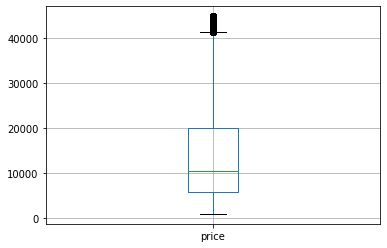

In [17]:
#decided to set the range of price to more realistic numbers, so that the standard deviations would be calculated to a more realistic number than 8,194,598.
vehicles_df = vehicles_df[vehicles_df['price'].between(999.99, 500000)]
Q1 = vehicles_df['price'].quantile(0.25)
Q3 = vehicles_df['price'].quantile(0.75)
IQR = Q3 - Q1
# Filtering Values between Q1-1.5IQR and Q3+1.5IQR
df_filtered = vehicles_df.query('(@Q1 - 1.5 * @IQR) <= price <= (@Q3 + 1.5 * @IQR)')
df_filtered.boxplot('price')

In [40]:
#the max number for year is 2020 and the max number for odometer is over 200,000
# cant be newer than 2020
df_filtered = df_filtered[df_filtered['year'].between(1900, 2020)]

#used the code below to set the ranges for odometer to 0–271,341.5
df_filtered = df_filtered[df_filtered['odometer'].between(0, 271420.5)]

In [41]:
df_filtered = df_filtered[['price','region','year','manufacturer','model','cylinders','fuel','odometer','title_status','transmission','drive','type','paint_color','state']]

In [42]:
df_filtered.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,price,region,year,manufacturer,model,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
count,121329.000000,121329.000000,121329.000000,121329.000000,121329.000000,121329.000000,121329.000000,121329.000000,121329.000000,121329.000000,121329.000000,121329.000000,121329.000000,121329.000000
mean,14238.241352,196.176504,2010.054711,18.715130,5992.345367,4.593444,1.960150,102196.101559,0.195205,0.226912,0.814991,6.060431,5.579507,23.973955
std,10690.351361,119.386760,7.627102,11.183974,3287.211327,1.258175,0.488176,59868.671833,0.879018,0.583084,0.769104,4.031312,3.998068,14.855981
min,1000.000000,0.000000,1923.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5900.000000,85.000000,2007.000000,10.000000,3209.000000,3.000000,2.000000,54000.000000,0.000000,0.000000,0.000000,2.000000,1.000000,9.000000
50%,10800.000000,198.000000,2012.000000,16.000000,5947.000000,5.000000,2.000000,100348.000000,0.000000,0.000000,1.000000,8.000000,7.000000,23.000000
75%,20000.000000,292.000000,2015.000000,30.000000,9046.000000,6.000000,2.000000,144000.000000,0.000000,0.000000,1.000000,9.000000,9.000000,37.000000
max,44850.000000,403.000000,2020.000000,40.000000,11683.000000,7.000000,4.000000,271420.000000,5.000000,2.000000,2.000000,12.000000,11.000000,50.000000


##MODELLING

In [25]:
#In order to prepare data for predictive modeling we will use Label Encoder since we have many categories for categorical variables
le = preprocessing.LabelEncoder()

In [26]:
df_filtered[['region','manufacturer','model','cylinders','fuel','title_status','transmission','drive'
             ,'type','paint_color','state']] = df_filtered[['region','manufacturer','model','cylinders','fuel','title_status',
                                                            'transmission','drive','type','paint_color','state']].apply(le.fit_transform)

In [27]:
from sklearn.preprocessing import StandardScaler
X_head = df_filtered.iloc[:, df_filtered.columns != 'price']
X = df_filtered.loc[:, df_filtered.columns != 'price']
y = df_filtered['price']
X = StandardScaler().fit_transform(X)

#Decided to use the random forest algorithm for a number of reasons:
#It handles high-dimensionality very well since it takes subsets of data.
#It is extremely versatile and requires very little preprocessing
#It is great at avoiding overfitting since each decision tree has low bias
#It allows you to check for feature importance, which you’ll see in the next section!

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)
model = RandomForestRegressor(random_state=1)
model.fit(X_train, y_train)
pred = model.predict(X_test)

##Checking accuracy of the model

In [43]:
print(mae(y_test, pred))
print(df_filtered['price'].mean())
model.score(X_test,y_test)
print('R2 score: ', round(r2_score(y_test, pred), 3))

1631.3780128595258
14238.241352026309
R2 score:  0.925
